# The DeepSensor package

*WIP Intro text*
DeepSensor is a Python package for modelling environmental data with neural processes (NPs).

DeepSensor wraps around `neuralprocesses`, an NP library, for the core modelling functionality.
DeepSensor provides additional functionality for data processing, data loading, inference, and active learning.

All you need is your `pandas` and `xarray` data.

The level of abstraction in `deepsensor` aims to massively lowers the barrier to entry for non-experts and automate away the frustrating details for experts, while also allowing flexibility when needed.

This notebook demonstrates an end-to-end modelling pipeline using `deepsensor` functionality.

## Imports/set-up

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

You must import either the `torch` or `tensorflow` extensions of deepsensor before other deepsensor modules. This ensures `deepsensor` has access to the deep learning library backend.


In [2]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor

In [3]:
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.models import ConvNP

from deepsensor.data.loader import construct_x1x2_ds, construct_circ_time_ds
from deepsensor.model.nps import compute_encoding_tensor
from deepsensor.plot.utils import plot_context_encoding, plot_offgrid_context

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import json

import lab as B

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")

from pprint import pprint
from tqdm.notebook import tqdm

In [5]:
if deepsensor.backend.str == "torch":
    # Run on GPU if available
    import torch
    if torch.cuda.is_available():
        # Set default GPU device
        torch.set_default_device("cuda")
        B.set_global_device("cuda:0")
elif deepsensor.backend.str == "tensorflow":
    # Run on GPU if available
    import tensorflow as tf
    if tf.test.is_gpu_available():
        # Set default GPU device
        tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
        B.set_global_device("GPU:0")
    # Check GPU visible to tf
    # print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Load your data!

In [6]:
# era5_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/gridded/processed/*/*.nc')
era5_raw_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [7]:
aux_raw_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [8]:
station_raw_df = pd.read_csv('../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'station', 'y', 'x']).sort_index()[['tas']]
station_raw_df

tas
time       station          y             x                       
1948-04-01 Macquarie_Island -3.638593e+06  1.401585e+06   5.885714
1948-04-02 Macquarie_Island -3.638593e+06  1.401585e+06   6.675000
1948-04-03 Macquarie_Island -3.638593e+06  1.401585e+06   4.775000
1948-04-04 Macquarie_Island -3.638593e+06  1.401585e+06   5.150000
1948-04-05 Macquarie_Island -3.638593e+06  1.401585e+06   4.037500
...                                                            ...
2022-06-14 Sky_Blu           5.380525e+05 -1.606516e+06 -24.912500
2022-06-15 Butler Island     9.847784e+05 -1.717203e+06 -19.669524
           Limbert           8.072843e+05 -1.351549e+06 -23.887500
           Rothera           9.270759e+05 -2.308923e+06  -9.895833
           Sky_Blu           5.380525e+05 -1.606516e+06 -26.587500

[941850 rows x 1 columns]

## Data processing

We will now normalise data (either to have zero mean and unit variance or lie in [-1, 1]), and standardise the spatial coordinates to be in the range [0, 1].

TODO
- Note on variable IDs inferred from data names here?

### Normalise data with DataProcessor

When instantiating a `DataProcessor` object, specify the names of the spatial coordinates and their raw values to normalise to 0 and 1.

In [9]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)

In [10]:
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.050, std=3.834
Normalisation params for tas not computed. Computing now... Done. tas mean=-16.262, std=14.696
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [11]:
pprint(data_processor.norm_params)

{'coords': {'x1': {'map': (0, 3500000.0), 'name': 'y'},
            'x2': {'map': (0, 3500000.0), 'name': 'x'}},
 'mask': {'max': 1.0, 'min': 0.0},
 'surface': {'max': 4047.721923828125, 'min': 0.0},
 't2m': {'mean': 0.05024006962776184, 'std': 3.8340163230895996},
 'tas': {'mean': -16.261720883718514, 'std': 14.695655954303945}}


The normalised data now has standardised `x1` and `x2` coordinates, and the data has been normalised to have zero mean and unit variance.

In [12]:
era5_ds

<xarray.Dataset>
Dimensions:    (time: 25933, x1: 280, x2: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * x1         (x1) float64 0.9964 0.9893 0.9821 ... -0.9821 -0.9893 -0.9964
  * x2         (x2) float64 -0.9964 -0.9893 -0.9821 ... 0.9821 0.9893 0.9964
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, x1, x2) float32 -0.1377 -0.1358 -0.131 ... 0.05715 0.0261

In [13]:
aux_ds

<xarray.Dataset>
Dimensions:  (x1: 280, x2: 280)
Coordinates:
  * x1       (x1) float64 0.9964 0.9893 0.9821 0.975 ... -0.9821 -0.9893 -0.9964
  * x2       (x2) float64 -0.9964 -0.9893 -0.9821 ... 0.9821 0.9893 0.9964
    lat      (x1, x2) float32 -44.58 -44.76 -44.93 ... -44.93 -44.76 -44.58
    lon      (x1, x2) float32 -45.0 -44.79 -44.59 -44.38 ... 135.4 135.2 135.0
Data variables:
    surface  (x1, x2) float32 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    mask     (x1, x2) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [14]:
station_df

tas
time       station          x1        x2                 
1948-04-01 Macquarie_Island -1.039598  0.400453  1.507074
1948-04-02 Macquarie_Island -1.039598  0.400453  1.560782
1948-04-03 Macquarie_Island -1.039598  0.400453  1.431492
1948-04-04 Macquarie_Island -1.039598  0.400453  1.457010
1948-04-05 Macquarie_Island -1.039598  0.400453  1.381308
...                                                   ...
2022-06-14 Sky_Blu           0.153729 -0.459005 -0.588662
2022-06-15 Butler Island     0.281365 -0.490629 -0.231892
           Limbert           0.230653 -0.386157 -0.518914
           Rothera           0.264879 -0.659692  0.433182
           Sky_Blu           0.153729 -0.459005 -0.702642

[941850 rows x 1 columns]

### Saving normalisation parameters for later
A `DataProcessor` object can be initialised with pre-computed normalisation parameters.

In [15]:
with open('norm_params.json', 'w') as f:
    json.dump(data_processor.norm_params, f)

In [16]:
norm_params = json.load(open('norm_params.json', 'r'))
data_processor = DataProcessor(norm_params)
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'x1': {'map': [0, 3500000.0], 'name': 'y'},
            'x2': {'map': [0, 3500000.0], 'name': 'x'}},
 'mask': {'max': 1.0, 'min': 0.0},
 'surface': {'max': 4047.721923828125, 'min': 0.0},
 't2m': {'mean': 0.05024006962776184, 'std': 3.8340163230895996},
 'tas': {'mean': -16.261720883718514, 'std': 14.695655954303945}}


### Aside: Unnormalisation with the DataProcessor
This will be useful when it comes to mapping model predictions back from normalised space to raw data space.

In [17]:
era5_unnorm_ds, station_unnorm_df = data_processor.unnormalise([era5_ds, station_df])
aux_unnorm_ds = data_processor.unnormalise(aux_ds, method="min_max")

The normalised data has been mapped back to the raw data values (including coordinates):

In [18]:
era5_unnorm_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, y, x) float32 -0.4777 -0.4703 -0.4519 ... 0.2694 0.1503

In [19]:
station_unnorm_df

tas
time       station          y             x                       
1948-04-01 Macquarie_Island -3.638593e+06  1.401585e+06   5.885714
1948-04-02 Macquarie_Island -3.638593e+06  1.401585e+06   6.675000
1948-04-03 Macquarie_Island -3.638593e+06  1.401585e+06   4.775000
1948-04-04 Macquarie_Island -3.638593e+06  1.401585e+06   5.150000
1948-04-05 Macquarie_Island -3.638593e+06  1.401585e+06   4.037500
...                                                            ...
2022-06-14 Sky_Blu           5.380525e+05 -1.606516e+06 -24.912500
2022-06-15 Butler Island     9.847784e+05 -1.717203e+06 -19.669524
           Limbert           8.072843e+05 -1.351549e+06 -23.887500
           Rothera           9.270759e+05 -2.308923e+06  -9.895833
           Sky_Blu           5.380525e+05 -1.606516e+06 -26.587500

[941850 rows x 1 columns]

### Add extra auxiliary information
Adding coordinate fields helps with learning spatial non-stationarity, and adding time fields helps with learning temporal non-stationarity.

In [20]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

## Loading tasks

### Set up a TaskLoader object
Note the flexibility of the `TaskLoader` init arguments below.
With slight changes to the arguments, we can instantiate a `TaskLoader` that generates tasks for forecasting or interpolation.

In [21]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [22]:
# task_loader.load_dask()  # Load any dask arrays into memory for faster training

### The TaskLoader outputs Tasks, which are dict-like objects containing context and target data

Calling a `TaskLoader` with a `date` generates a `Task` for that date by slicing the context and target variables.
`Task`s inherit from `dict` and provide `__str__` and `__repr__` methods for debugging.
`TaskLoader` offers several data sampling methods for generating `Task`s.
```
"all": sample all observations (i.e. all grid cells for gridded xarray data)
N, int: uniform random sampling of N observations (i.e. grid cells for gridded xarray data)
```

In [23]:
task = task_loader("2000-01-01", "all", 10)
print(type(task), "\n")

print("Concise task summary:")
print(task)

print("Verbose task summary:")
print(repr(task))

<class 'deepsensor.data.task.Task'> 

Concise task summary:
time: 2000-01-01 00:00:00
flag: None
X_c: [((280,), (280,)), ((280,), (280,))]
Y_c: [(1, 280, 280), (6, 280, 280)]
X_t: [(2, 10)]
Y_t: [(10,)]

Verbose task summary:
time: Timestamp/2000-01-01 00:00:00
flag: NoneType/None
X_c: [('ndarray/float32/(280,)', 'ndarray/float32/(280,)'), ('ndarray/float32/(280,)', 'ndarray/float32/(280,)')]
Y_c: ['ndarray/float32/(1, 280, 280)', 'ndarray/float32/(6, 280, 280)']
X_t: ['ndarray/float32/(2, 10)']
Y_t: ['ndarray/float32/(10,)']



## Initialise model

### Set up ConvNP object

`ConvNP` wraps around the `neuralprocesses` library to provide a convenient interface for inference with environmental data in the form of `Task`s.

There are several ways to set up a `ConvNP` object.

Advanced users can instantiate a ConvNP from an existing `neuralprocesses` model working in pure `neuralprocesses` for more flexibility.


In [24]:
custom_model = deepsensor.backend.nps.construct_convgnp()
model = ConvNP(data_processor, task_loader, custom_model)

However, we will instantiate a ConvNP with a TaskLoader to infer sensible defaults (unless overridden with `neuralprocesses.construct_convgnp` kwargs).
The TaskLoader and DataProcessor will also be used to unnormalise model predictions at inference time.


In [25]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="het")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]


A `ConvNP`'s `__call__` method accepts a `Task` and returns a distribution object.
The distribution object can be used to compute predictions, sample from the model, compute entropy, etc, without having to run the model again.

In [26]:
# Run model on a random task to build model, with all context data and 3 random target locations
task = task_loader("2000-01-01", "all", 3)
task = ConvNP.modify_task(task)

dist = model(task)
print('Distribution object: ', type(dist))
x = model.mean(dist)
print('Mean: ', x.shape, x)
x = model.sample(dist, n_samples=2)
print('Sample: ', x.shape, x)
x = model.variance(dist)
print('Variance: ', x.shape, x)
x = model.stddev(dist)
print('Std dev: ', x.shape, x)
x = model.covariance(dist)
print('Covariance: ', x.shape)
x = model.logpdf(dist, task)
print('logpdf: ', x)
x = model.entropy(dist)
print('Entropy: ', x)

Distribution object:  <class 'neuralprocesses.dist.normal.MultiOutputNormal[matrix.matrix.Dense, matrix.constant.Zero, matrix.diagonal.Diagonal]'>
Mean:  (1, 3) [[-3.5071087 -4.2212167 -3.5676157]]
Sample:  (2, 1, 3) [[[-3.5071087 -4.2212167 -3.5676157]]

 [[-3.5071087 -4.2212167 -3.5676157]]]
Variance:  (1, 3) [[2.8676443 0.7078982 0.950005 ]]
Std dev:  (1, 3) [[1.6934121 0.8413669 0.974682 ]]
Covariance:  (1, 3, 3)
logpdf:  -24.269264
Entropy:  [4.5851893]


Note, all of the above methods can be called on a `Task` rather than a distribution object, and the model will be run internally, e.g.:

In [27]:
x = model.mean(task)
print('Mean: ', x.shape, x)

Mean:  (1, 3) [[-3.5071087 -4.2212167 -3.5676157]]


After model has been built, we can get some useful information:

In [28]:
print(f"Model receptive field: {model.model.receptive_field:.2f}")
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

Model receptive field: 0.39
Model has 232,055 parameters


The model has a method to reshape the task data into a format that can be passed to the model:

In [29]:
task = ConvNP.modify_task(task)
print(repr(task))

time: Timestamp/2000-01-01 00:00:00
flag: str/NPS
X_c: [('Tensor/torch.float32/torch.Size([1, 280])', 'Tensor/torch.float32/torch.Size([1, 280])'), ('Tensor/torch.float32/torch.Size([1, 280])', 'Tensor/torch.float32/torch.Size([1, 280])')]
Y_c: ['Tensor/torch.float32/torch.Size([1, 1, 280, 280])', 'Tensor/torch.float32/torch.Size([1, 6, 280, 280])']
X_t: ['Tensor/torch.float32/torch.Size([1, 2, 3])']
Y_t: ['Tensor/torch.float32/torch.Size([1, 3])']



### Visualise encoded context data in the model
Inspecting the gridded encoding of the context data helps with understanding the context sampling schemes.

This can also be an extremely useful debugging tool. For example:
* Do the length scales of the encoded data seem reasonable (i.e. avoids blurring high frequency components while not being so small to induce checkerboard artefacts)?
* Are the channel magnitudes in the encoding reasonable?
* Are there any `nan` values?


Encoding is shape (9, 384, 384)


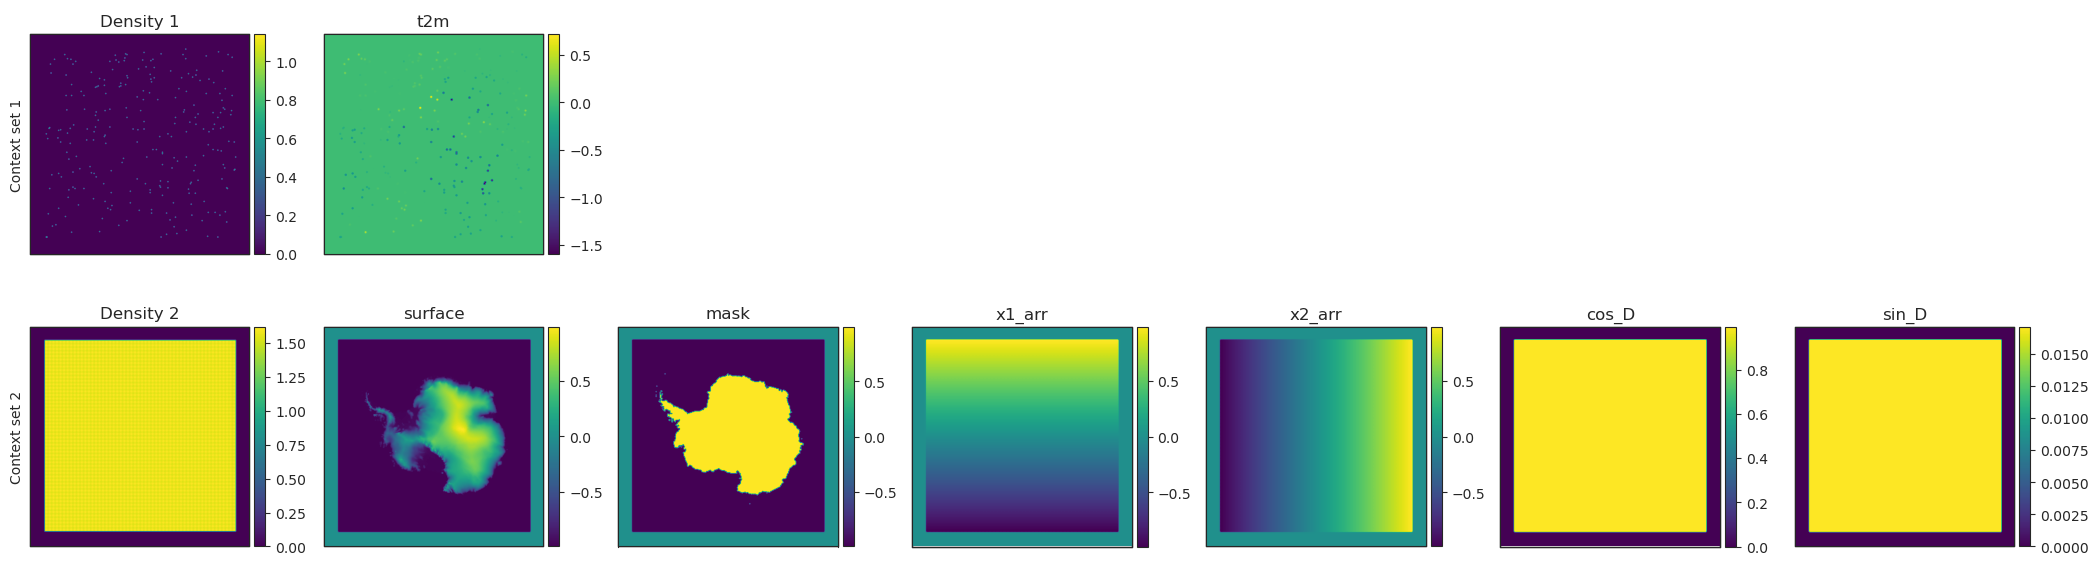

In [30]:
task = task_loader("2000-01-01", (250, "all"), 5000)
encoding = compute_encoding_tensor(model, task)
print(f"\nEncoding is shape {encoding.shape}")
fig = plot_context_encoding(model, task, task_loader)
plt.show()

It's a little hard to see the first encoded context set, so we can plot it separately and increase the figure size:

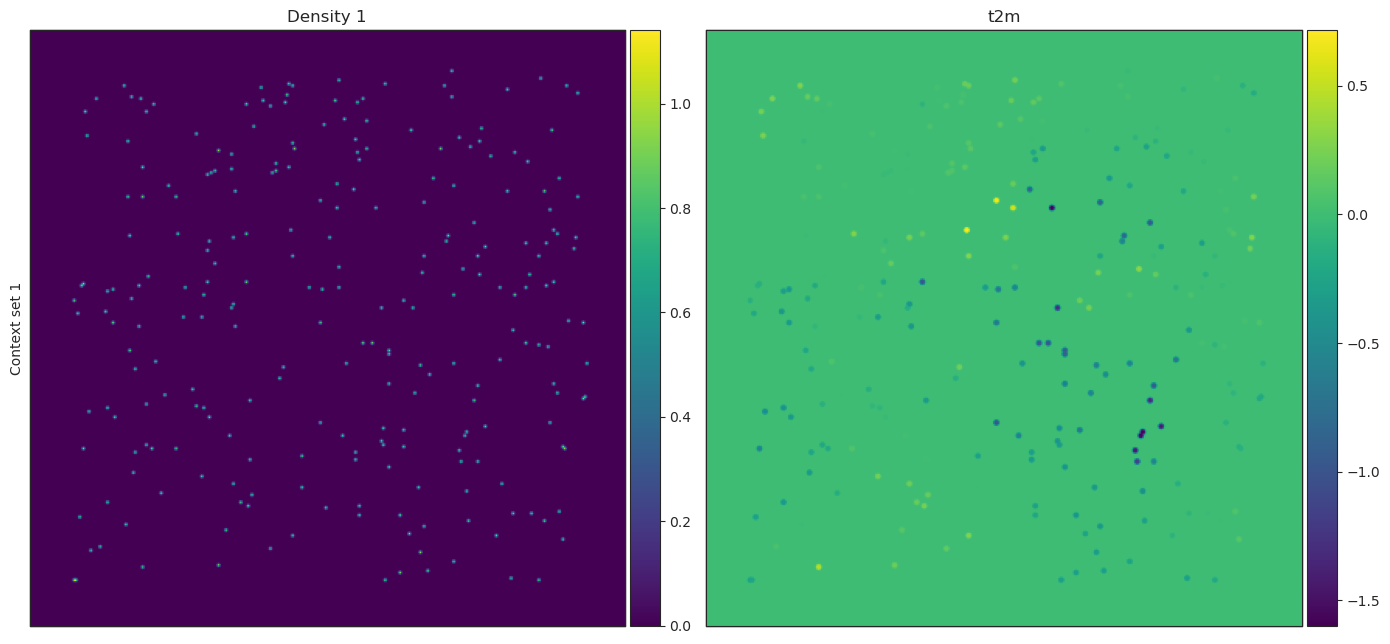

In [31]:
fig = plot_context_encoding(model, task, task_loader, context_set_idxs=0, size=7)
plt.show()

## Train model

The `model` attribute of a `ConvNP` object exposes the raw `neuralprocesses` model.
The model can be trained with vanilla `tensorflow` or `torch` approaches, as illustrated below.

In [32]:
if deepsensor.backend.str == 'tf':
    import tensorflow as tf

    opt = tf.keras.optimizers.Adam(5e-5)

    def train_step(tasks):
        if not isinstance(tasks, list):
            tasks = [tasks]
        with tf.GradientTape() as tape:
            task_losses = []
            for task in tasks:
                task_losses.append(model.loss_fn(task, normalise=True))
            mean_batch_loss = B.mean(task_losses)
        grads = tape.gradient(mean_batch_loss, model.model.trainable_weights)
        opt.apply_gradients(zip(grads, model.model.trainable_weights))
        return mean_batch_loss

elif deepsensor.backend.str == 'torch':
    import torch.optim as optim

    opt = optim.Adam(model.model.parameters(), lr=5e-5)

    def train_step(tasks):
        if not isinstance(tasks, list):
            tasks = [tasks]
        opt.zero_grad()
        task_losses = []
        for task in tasks:
            task_losses.append(model.loss_fn(task, normalise=True))
        mean_batch_loss = B.mean(torch.stack(task_losses))
        mean_batch_loss.backward()
        opt.step()
        return mean_batch_loss.detach().cpu().numpy()
else:
    raise NotImplementedError(f"Backend {deepsensor.backend.str} not implemented")

In [33]:
n_epochs = 10
epoch_losses = []
for epoch in tqdm(range(n_epochs), position=0):
    dates = pd.date_range('1980-01-01', '2009-11-30')[::365]
    batch_losses = []
    for date in dates:
        n_obs = np.random.randint(5, 5000)  # Random number of context observations
        n_t = 5000  # Number of target points
        task = task_loader(date, (n_obs, "all"), n_t)  # Generate task with all auxiliary context
        batch_loss = train_step(task)
        batch_losses.append(batch_loss)

    epoch_loss = np.mean(batch_losses)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch} loss: {epoch_loss:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 loss: 2.47
Epoch 1 loss: 1.35
Epoch 2 loss: 0.99
Epoch 3 loss: 0.52
Epoch 4 loss: 0.21
Epoch 5 loss: 0.08
Epoch 6 loss: 0.08
Epoch 7 loss: -0.09
Epoch 8 loss: -0.05
Epoch 9 loss: -0.03


Text(0.5, 0, 'epoch')

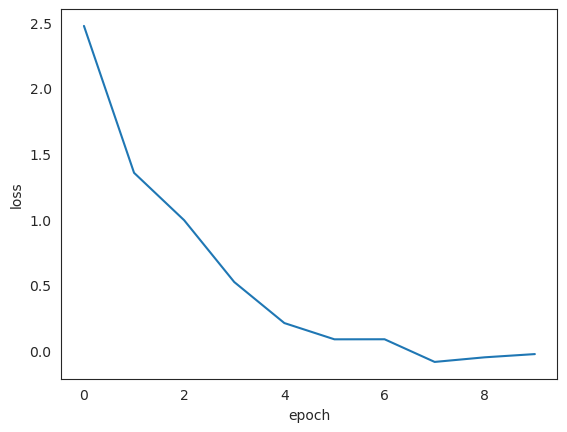

In [34]:
plt.plot(epoch_losses)
plt.gca().set_ylabel("loss")
plt.gca().set_xlabel("epoch")

However, to save time, we will load a pre-trained model.

In [35]:
load_weights = True
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("model.h5")
    elif deepsensor.backend.str == "torch":
        model.model.load_state_dict(torch.load("model.pt"))

## Predict on heldout data

The `ConvNP` parent class, `DeepSensorModel`, provides a `predict_ongrid` method to map from tasks to a gridded `xarray` object of predictions.

### Predicting on a regular grid

The `predict_ongrid` method receives `Task` objects containing context data and an `xr.Dataset` containing the target prediction locations.
By default the target locations are assumed to be in raw (unnormalised) form, which are more natural to work with.
However, this can be changed by setting `X_t_normalised=True`.

In [36]:
test_date = pd.Timestamp("2014-01-01")
task = task_loader(test_date, context_sampling=(100, "all"))

In [37]:
mean_ds, std_ds = model.predict(task, X_t=era5_raw_ds)
print(mean_ds)
print('\n')
print(std_ds)

<xarray.Dataset>
Dimensions:  (time: 1, y: 280, x: 280)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float32 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float32 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
Data variables:
    t2m      (time, y, x) float32 0.3885 0.5957 0.7242 ... 0.2734 0.2793 0.2352


<xarray.Dataset>
Dimensions:  (time: 1, y: 280, x: 280)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float32 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float32 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
Data variables:
    t2m      (time, y, x) float32 1.2 1.164 1.186 1.235 ... 0.3334 0.3646 0.3698


In [38]:
err_da = mean_ds - era5_raw_ds
err_da

<xarray.Dataset>
Dimensions:    (time: 1, y: 258, x: 258)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(1, 258, 258), meta=np.ndarray>

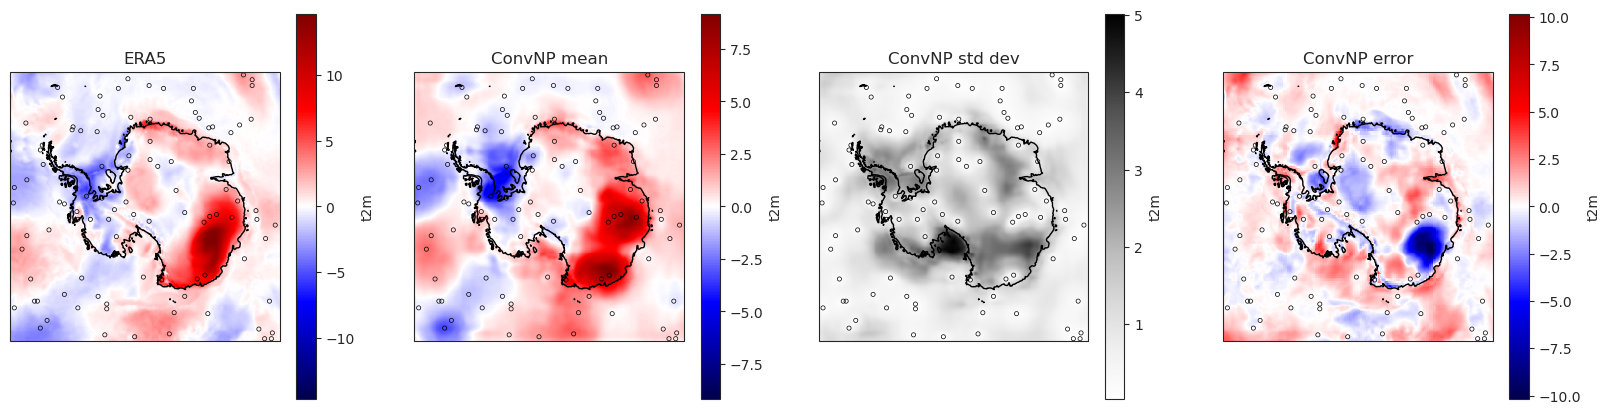

In [39]:
crs = ccrs.LambertAzimuthalEqualArea(0, -90)
fig, axes = plt.subplots(subplot_kw={"projection": crs}, nrows=1, ncols=4, figsize=(20, 5))
era5_raw_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[0])
axes[0].set_title("ERA5")
mean_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[1])
axes[1].set_title("ConvNP mean")
std_ds["t2m"].sel(time=task["time"]).plot(cmap="Greys", ax=axes[2])
axes[2].set_title("ConvNP std dev")
err_da["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[3])
axes[3].set_title("ConvNP error")
plot_offgrid_context(axes, task, data_processor, s=3**2, linewidths=0.5)
for ax in axes:
    ax.coastlines()

In [40]:
mae = dask.array.fabs(err_da["t2m"]).mean()
rmse = np.sqrt(dask.array.square(err_da["t2m"]).mean())
print(f"Test MAE: {mae.values:.2f} K, RMSE: {rmse.values:.2f} K")

Test MAE: 0.76 K, RMSE: 1.24 K



### Predicting at off-grid locations

Simply pass a pandas `Index` (or a `DataFrame`) containing the target locations as the `X_t` argument to `predict`.
The spatial coordinates in `X_t` will be set as the target prediction locations.
The model will return `DataFrame`s containing predictions. These will include a `'time'` index based on the `Task`s passed to the `predict` method.

Note, any indexes in `X_t` other than the spatial coordiantes will also be copied to the output `pandas` objects.
This is useful for maintaining metadata such as station names.

In [41]:
test_dates = pd.date_range("2014-01-01", "2014-03-31")
tasks = task_loader(test_dates, (100, "all"), 0, deterministic=True)

In [42]:
X_t = station_raw_df.loc["2014-01-01"].index  # If you pass a DataFrame, the index will be used as X_t
print(X_t)

MultiIndex([('Alessandra(Cape King)',  -1777652.513653347, ...),
            (       'Amundsen_Scott',                 0.0, ...),
            (        'Backer_Island', -374491.29991695134, ...),
            (       'Bear_Peninsula',  -641280.3552739318, ...),
            (          'Belgrano_II',  1113058.0195212185, ...),
            (       'Bellingshausen',  1588707.7460916566, ...),
            (      'Bennett_Nunatak', -259363.89191715384, ...),
            (      'Bonaparte Point',   1221071.526363026, ...),
            (              'Brianna',  -475109.9761098527, ...),
            (       'Brimstone_Peak',  -1471757.645892819, ...),
            (        'Butcher_Ridge', -1104670.4157267022, ...),
            (        'Butler Island',   984778.4462872308, ...),
            (                 'Byrd',  -547558.4899320819, ...),
            (         'Cape_Framnes',  1306652.3977296087, ...),
            (              'Carolyn',  -1118045.657077448, ...),
            (            

In [43]:
mean_df, std_df = model.predict(tasks, X_t, progress_bar=True)
print(mean_df)
print('\n')
print(std_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 30.18it/s]

                                                                   t2m
time       station               y             x                      
2014-01-01 Alessandra(Cape King) -1.777653e+06  4.228409e+05  0.829866
           Amundsen_Scott         0.000000e+00  0.000000e+00   1.77944
           Backer_Island         -3.744913e+05 -1.692314e+06  -1.08272
           Bear_Peninsula        -6.412804e+05 -1.596502e+06  0.173425
           Belgrano_II            1.113058e+06 -7.683253e+05 -2.756745
...                                                                ...
2014-03-31 White Island          -1.298725e+06  2.758157e+05  0.323016
           Whitlock              -1.512417e+06  3.107296e+05 -0.135866
           Whitmore_Mountains    -2.029890e+05 -7.910077e+05   2.33665
           Wilson_Nunatak         1.822629e+05 -1.095921e+06 -1.996068
           Zhongshan              5.400571e+05  2.226660e+06  1.734251

[7470 rows x 1 columns]


                                                  

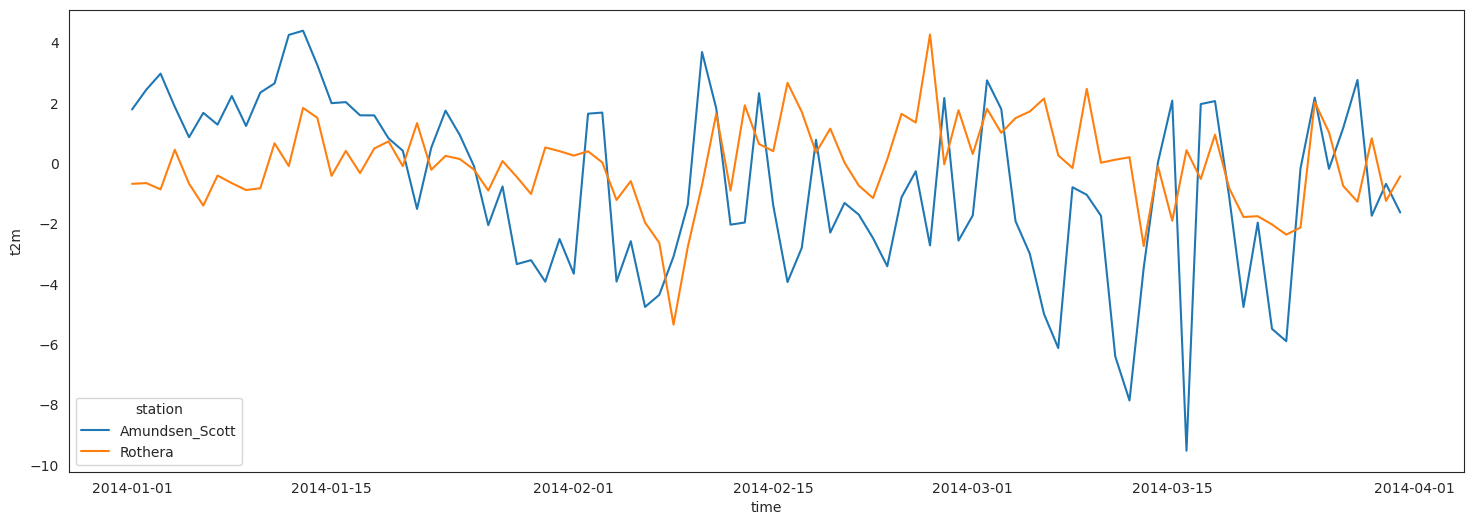

In [44]:
plot_df = mean_df.reset_index().set_index('station').loc[['Amundsen_Scott', 'Rothera']]
# plot_df = samples_df.reset_index().set_index('station').loc[['Amundsen_Scott', 'Rothera']]

fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(
    data=plot_df,
    x='time',
    y='t2m',
    hue='station',
    ax=ax,
)
plt.show()